# Градієнтний бустінг своїми руками

У цьому завданні буде використовуватися датасета `boston` з` sklearn.datasets`. Залиште останні 25% об'єктів для контролю якості, розділивши `X` і` y` на `X_train`,` y_train` і `X_test`,` y_test`.

Метою завдання буде реалізувати простий варіант градиентного бустінга над регресійними деревами для випадку квадратичної функції втрат.

#### Встановлення найновіших біблотек, щоб не було проблем з числовими відповідями

In [1]:
# Перевірочні дані для лабораторної роботи отримані з використанням таких версій бібліотек 
!pip install "scikit-learn == 0.24.2"
!pip install "numpy == 1.22.4" 
!pip install "pandas == 1.5.2" 
!pip install "xgboost == 1.7.1" 
!python --version Python 3.9.7

Python 3.9.13


In [2]:
import pandas
import sklearn
from sklearn import ensemble , model_selection,  datasets, metrics, tree, linear_model 
import xgboost as xgb
import numpy as np
import pandas as pd

In [3]:
print('sklearn',sklearn.__version__)
print('numpy',np.__version__)
print('pandas',pd.__version__)
print('xgboost',xgb.__version__)

sklearn 0.24.2
numpy 1.22.4
pandas 1.5.2
xgboost 1.7.1


**Версії**
- sklearn 0.24.2
- numpy 1.22.4
- pandas 1.5.2
- xgboost 1.7.1

## Завдання 1

Як ви вже знаєте з лекцій, **бустінг** - це метод побудови композицій базових алгоритмів за допомогою послідовного додавання до поточної композиції нового алгоритму з деяким коефіцієнтом.

Метод найшвидшого бустінгу навчає кожен новий алгоритм так, щоб він наближав антіградіент помилки за відповідями композиції на навчальній вибірці. Аналогічно мінімізації функцій методом градієнтного спуску, в градієнтному бустінгу ми підправляємо композицію, змінюючи алгоритм в напрямку антіградіента помилки.

Скористайтеся формулою з лекцій, яка задає відповіді на навчальній вибірці, на які потрібно навчати новий алгоритм (фактично це лише трохи більш докладно розписаний градієнт від помилки), і отримаєте частковий її випадок, якщо функція втрат `L` - квадрат відхилення відповіді композиції `a(x)`від правильної відповіді `y` на даному `x`.

Якщо ви давно не брали похідну самостійно, вам допоможе таблиця похідних елементарних функцій (яку нескладно знайти в інтернеті) і правило диференціювання складної функції. Після диференціювання квадрата у вас виникне множник 2 - тому що нам все одно доведеться вибирати коефіцієнт, з яким буде додано новий базовий алгоритм, проігноіруйте цей множник при подальшому побудові алгоритму.

## Завдання 2

Заведіть масив для об'єктів `DecisionTreeRegressor` (будемо їх використовувати в якості базових алгоритмів) і для дійсних чисел (це будуть коефіцієнти перед базовими алгоритмами).

У циклі від навчіть послідовно 50  дерев рішень з параметрами `max_depth = 5` і` random_state = 42` (інші параметри - за замовчуванням). У бустінге часто використовуються сотні і тисячі дерев, але ми обмежимося 50, щоб алгоритм працював швидше, і його було простіше налагоджувати (тому що мета завдання розібратися, як працює метод). Кожне дерево має навчатися на одній і тій же множині  об'єктів, але відповіді, які вчиться прогнозувати дерево, будуть змінюватися у відповідністі з отриманими в завданні 1 правилом.

Спробуйте для початку завжди брати коефіцієнт рівним 0.9. Зазвичай виправдано вибирати коефіцієнт значно меншим - близько 0.05 або 0.1, але тому що в нашому навчальному прикладі на стандартному датасета буде всього 50 дерев, візьмемо для початку крок побільше.

В процесі реалізації навчання вам буде потрібно функція, яка буде обчислювати прогноз побудованої на даний момент композиції дерев на вибірці `X`:

```
def gbm_predict (X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(Вважаємо, що base_algorithms_list - список з базовими алгоритмами, coefficients_list - список з коефіцієнтами перед алгоритмами)
```

Ця ж функція допоможе вам отримати прогноз на контрольній вибірці і оцінити якість роботи вашого алгоритму за допомогою `mean_squared_error` в` sklearn.metrics`.

Підведіть результат в ступінь 0.5, щоб отримати `RMSE`. Отримане значення `RMSE` - **відповідь в пункті 2**.

Передайте відповідь в функцію **write_answer_2**.

In [4]:
from sklearn.tree import DecisionTreeRegressor

In [5]:
from sklearn.metrics import mean_squared_error as mse_

Може виникнути помилка. Тому 2 варіанти завантаження датасету.

* 1 варіант

In [6]:
data = datasets.load_boston() 

In [7]:
X = data['data']
y = data['target']
print(X.shape, y.shape) # (506, 13) (506,)

(506, 13) (506,)


* 2 варіант

In [8]:
X_train, X_test, y_train, y_test = \
                 model_selection.train_test_split(X, y, test_size = 0.25, random_state = 1)
print(X_train.shape, X_test.shape)
# (379, 13) (127, 13)

# 506*0.75 = 379.5
# 506*0.25 = 126.5
# 379 + 127 = 506

(379, 13) (127, 13)


In [9]:
def gbm_predict (X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in 
                 zip(base_algorithms_list, coefficients_list)]) for x in X]

#(Вважаємо, що base_algorithms_list - список з базовими алгоритмами, 
# coefficients_list - список з коефіцієнтами перед алгоритмами)

In [10]:
# середньоквадратична похибка
# L = L(y,z) = (y-z)^2
# L_ = dL(y,z) = 2*(y-z) - у ф-ції множник 2 ігноруємо
def L(y, z):
    # у - дані з вибірки
    # z - прогнозовані дані    
    return y - z

In [11]:
base_algorithms_list = [] # список (list()) з базовими алгоритмами
coefficients_list    = [] # список (list()) з коефіцієнтами перед алгоритмами

y_cur = np.array(y_train)

n_estimators = 50
for i in range(n_estimators):
    regressor = tree.DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_cur)
    base_algorithms_list.append(regressor)
    coefficients_list.append(0.9)
    
    y_cur = L(y_train, gbm_predict(X_train))
    
error2 = np.sqrt(mse_(y_test, gbm_predict(X_test)))

In [12]:
def write_answer_2(*answer):
    with open("GB_problem2.txt", "w") as fout:
        fout.write(" ".join([str(round(num,3)) for num in answer]))
        
write_answer_2(error2)  
print(error2)

3.8430207801594336


## Завдання 3

Вас може також турбувати, що рухаючись з постійним кроком, поблизу мінімуму помилки відповіді на навчальній вибірці змінюються занадто різко, перескакуючи через мінімум.

Спробуйте зменшувати вагу перед кожним алгоритмом з кожною наступною ітерацією за формулою `0.9 / (1.0 + i)`, де `i` - номер ітерації (від 0 до 49). Використовуйте якість роботи алгоритму як **відповідь в пункті 3**.

Передайте відповідь в функцію **write_answer_3**.

У реальності часто застосовується така стратегія вибору кроку: як тільки обраний алгоритм, підберемо коефіцієнт перед ним чисельним методом оптимізації таким чином, щоб відхилення від правильних відповідей було мінімальним. Ми не будемо пропонувати вам реалізувати це для виконання завдання, але рекомендуємо спробувати розібратися з такою стратегією і реалізувати її при нагоді для себе.

In [13]:
# Ваш код

base_algorithms_list = []
coefficients_list = []

y_cur = np.array(y_train)

n_estimators = 50
for i in range(n_estimators):
    regressor = tree.DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_cur)
    base_algorithms_list.append(regressor)
    coefficients_list.append(0.9 / (1.0 + i))
    
    y_cur = L(y_train, gbm_predict(X_train))

error3 = np.sqrt(mse_(y_test, gbm_predict(X_test)))

In [14]:
def write_answer_3(*answer):
    with open("GB_problem3.txt", "w") as fout:
        fout.write(" ".join([str(round(num,3)) for num in answer]))
        
write_answer_3(error3)
print(error3)

3.182177754260443


## Завдання 4

Реалізований вами метод - градієнтний бустінг над деревами - дуже популярний в машинному навчанні. Він представлений як в самій бібліотеці `sklearn`, так і в сторонньої бібліотеці `XGBoost`, яка має свій пітоновскій інтерфейс. На практиці `XGBoost` працює помітно краще` GradientBoostingRegressor` з `sklearn`, але для цього завдання ви можете використовувати будь-яку реалізацію (можете використовувати або `XGBoost`, або `GradientBoostingRegressor`).

Досліджуйте, перенавчається чи градієнтний бустінг з ростом числа ітерацій (і подумайте, чому), а також із зростанням глибини дерев. На основі спостережень випишіть через пробіл номери правильних з наведених нижче тверджень в порядку зростання номера (це буде **відповідь в п.4**):

    1. Зі збільшенням числа дерев, починаючи з деякого моменту, якість роботи градиентного бустінга не змінюється істотно.

    2. Зі збільшенням числа дерев, починаючи з деякого моменту, градієнтний бустінг починає перенавчатися.

    3. З ростом глибини дерев, починаючи з деякого моменту, якість роботи градиентного бустінга на тестовій вибірці починає погіршуватися.

    4. З ростом глибини дерев, починаючи з деякого моменту, якість роботи градиентного бустінга перестає суттєво змінюватися
    
Передайте відповідь в функцію **write_answer_4**.

In [15]:
# Ваш код

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
trees = np.array([5, 10, 15, 20, 30, 40, 50, 60, 70, 100]) # число дерев
depths = np.array([3, 5, 7, 10, 15, 22])                   # значення глибини дерева

[7.062768733208135, 5.343327536398778, 4.345832045229115]
[6.678911656070678, 4.972206754886331, 3.9887017877746875]
[6.69148012739386, 4.882615943835674, 4.074812068392879]
[6.646593229129778, 4.962539642925639, 4.20876526817856]
[6.660987852163279, 5.028263503999511, 4.428010995702001]
[6.597915170960161, 4.995683721656504, 4.401503829051195]


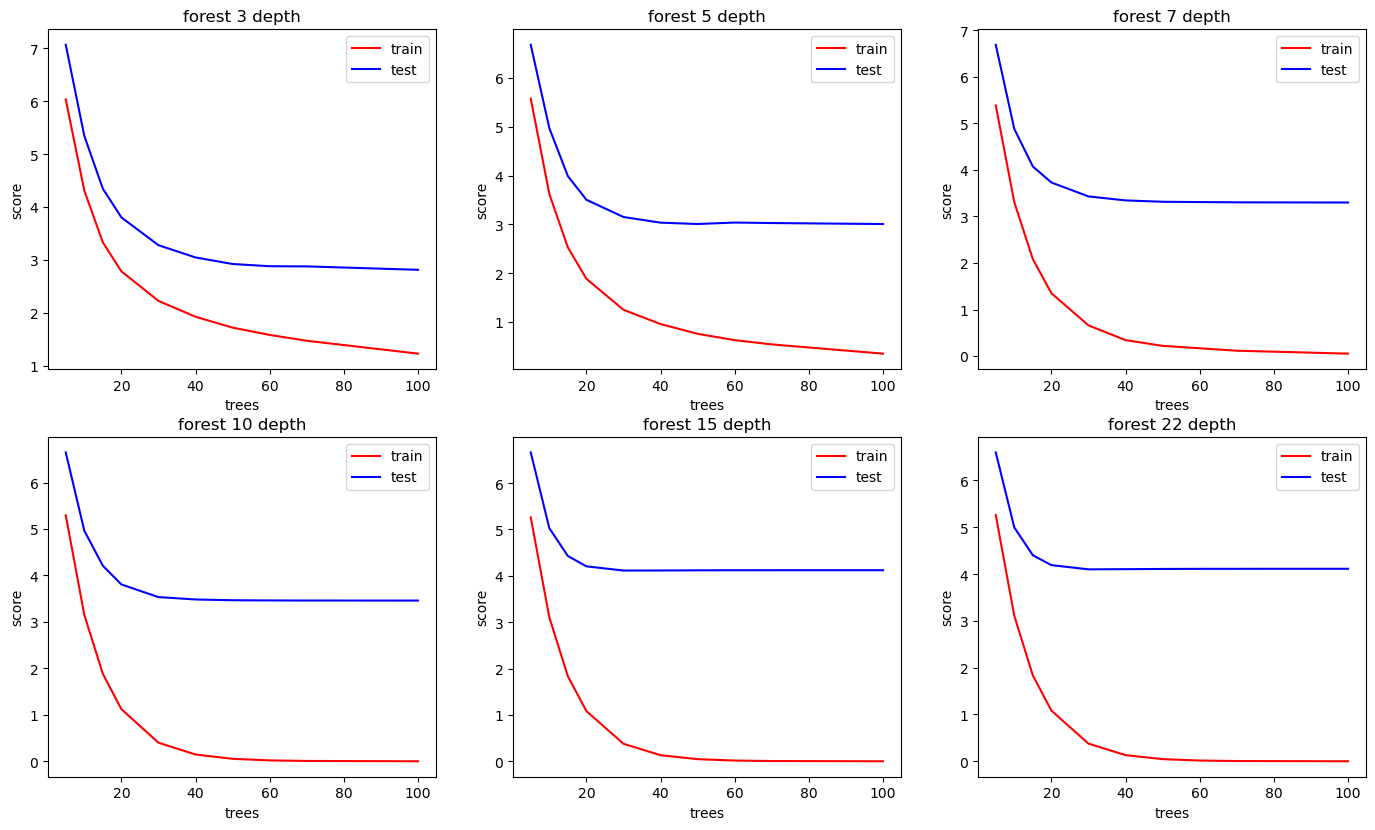

In [19]:
plt.figure(figsize=(17, 15))
i = 1
for d in depths:
    scores_train, scores_test = [], []
    for num in trees:
        boost = GradientBoostingRegressor(n_estimators = num, max_depth = d, random_state = 42).fit(X_train, y_train)
        scores_train.append(np.sqrt(mse_(y_train, boost.predict(X_train))))
        scores_test.append(np.sqrt(mse_(y_test, boost.predict(X_test))))
    print(scores_test[:3]) 
    ax = plt.subplot(3, 3, i)
    ax.set_title("forest {} depth".format(d))
    title("forest {} depth".format(d))
    plt.plot(trees, scores_train, color="red", label="train")
    plt.plot(trees, scores_test, color="blue", label="test")
    plt.xlabel("trees")
    plt.ylabel("score")
    plt.legend()
    i += 1


In [20]:
# Ввести необхідну кількість аргументів через кому в зростаючому порядку
def write_answer_4(*answer): 
    with open("GB_problem4.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answer]))
        
write_answer_4(2,3)        

## Завдання 5

Порівняйте отриману за допомогою градієнтного бустінга якість з якістю роботи лінійної регресії.

Для цього навчіть `LinearRegression` з` sklearn.linear_model` (з типовими параметрами) на навчальній вибірці та оцініть для прогнозів отриманого алгоритму на тестовій вибірці `RMSE`. Отримане якість - відповідь в **пункті 5**.

Передайте відповідь в функцію **write_answer_5**.

В даному прикладі якість роботи простої моделі повинно було виявитися гірше, але не варто забувати, що так буває не завжди. У завданнях ви можете ще зустріти приклад зворотній ситуації.

In [21]:
# Ваш код
from sklearn.linear_model import LinearRegression

In [22]:
regr = LinearRegression().fit(X_train, y_train)
prediction = regr.predict(X_test)

error5 = np.sqrt(mse_(y_test, prediction))

In [23]:
def write_answer_5(*answer):
    with open("GB_problem5.txt", "w") as fout:
        fout.write(" ".join([str(round(num,3)) for num in answer]))
        
write_answer_5(error5)     
print(error5)

4.679504823808763
